## Lecture 5: Ensembles

### 1. `RandomForestClassifier`

#### 1.1 Idea: Combining multiple trees

1. Decision tree models are popular
    - Interpretable
    - Can capture non-linear relationships
    - Don't require scaling of the data
    - Theoretically can work with categorical features.


2. Single decision tree
    - Likely to overfit


3. Combining multiple trees
    - Can build stronger models
    - Popular in industry
    
    
4. What is a random forest?

```python
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
results['Random forests'] = mean_std_cross_val_scores(pipe_rf, X_train, y_train)
pd.DataFrame(results)
```

> A random forest creates a collection of trees. It grows each tree on an independent bootstrap sample from the data. It is a popular, off-the-shelf tree-based model.

**Fit**
- `fit` a diverse set of decision trees by **injecting randomness** in the classifier construction
    - 1) The model builds each tree on a bootstrap sample (a sample drawn **with replacement** from the training set) <- _random_! 
    - 2) Then, in each split, it considers a **random subset** of features. (so, every tree might have different features, and every split considers different features) <- _random_! 
    - At each node (tree):
        - 1) Randomly select a subset of features out of all features (independently for each node).
        - 2) Find the best split on the selected features.
        - 3) Grow the trees to maximum depth.
    
    
**Predict**
- `predict` by taking the average of predictions given by **individual classifiers(trees)**. 
    - **Vote the trees** to get predictions for new example.

#### 1.2 Hyperparameters
1. `n_estimators`
    - number of decision trees
    - higher = more complexity 
2. `max_depth`
    - max depth of each decision tree
    - higher = more complexity
3. `max_features`
    - number of features you get to look at each split
    - higher = more complexity

#### 1.3 Fundamental tradeoff
- For `max_depth`, the model is likely to overfit like `decision tree`. 
- However, for `n_estimators`:

    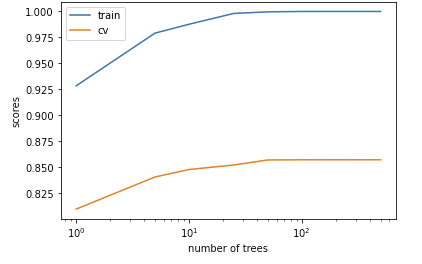

    - **The more trees the better (always!)**
    - No risk for overfitting when you have many trees. 

#### 1.4 Random forests vs decision trees

|                  | Random Forest                                                            | Decision Tree                    |
|------------------|--------------------------------------------------------------------------|----------------------------------|
| Accuracy         | More accurate<br> - One of the best performing off-the-shelf classifiers | Less accurate                    |
| Speed            | Slower<br> - Fitting multiple trees                                      | Faster                           |
| Overfitting      | Less likely to overfit                                                   | No max_depth = likely to overfit |
| Interpretability | Less interpretable                                                       | More interpretable               |

### 2. Other tree-based models

#### 2.1 XGBoost
- Supports missing values
- GPU training
- Supports sparse data
- Typically better scores than random forest

#### 2.2 LightGBM
- Small model size
- Fast
- Typically better scores than random forest

#### 2.3 CatBoost
- Usually better scores
- But slower compared to `XGBoost` and `LightGBM`

#### 2.4 Score comparison

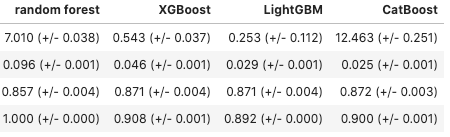

- All these results are with default hyperparameters
- Decision trees and random forests overfit
    - Other models do not seem to overfit much.
    
    
- Fit times
    - Decision trees are fast but not very accurate
    - `LightGBM` is faster than decision trees and more accurate!
    - `CatBoost` fit time is highest followed by random forests.
    - There is not much difference between the validation scores of `XGBoost`, `LightGBM`, and `CatBoost` but it is about 48x slower than `LightGBM`!
    - `XGBoost` and `LightGBM` are faster and more accurate than random forest!


- Scores times
    - Prediction times are much smaller in all cases.

#### 2.4 How to choose classifier
- Choose the one with getting the highest CV score
    - However, make sure that you are not overusing the validation set; optimization bias, your cv score might not be representative of your test scores.
- Interpretability
- Speed/code maintenance

> A RandomForestClassifier is a collection of DecisionTreeClassifier's. No matter how big your training set, a decision tree simply returns: a decision. One class has probability 1, the other classes have probability 0.

> The RandomForest simply votes among the results. predict_proba() returns the number of votes for each class (each tree in the forest makes its own decision and chooses exactly one class), divided by the number of trees in the forest. Hence, your precision is exactly 1/n_estimators. Want more "precision"? Add more estimators. 

### 3. Averaging

#### 3.1 `VotingClassifier`

```python
classifiers.keys() # use all the classifiers!
>>> dict_keys(['logistic regression', 'decision tree', 'random forest', 'XGBoost', 'LightGBM', 'CatBoost'])
```

```python
from sklearn.ensemble import VotingClassifier
averaging_model = VotingClassifier(list(classifiers.items()), voting='soft') # need the list() here for cross_val to work!
```

- `VotingClassifier` takes a vote using the predictions of the constituent classifier pipelines.


```python
averaging_model.fit(X_train, y_train);
```
- During `fit`, it fits all models that you passed.

#### 3.2 Hard voting / soft voting
- Main parameter: `voting`
    - `voting='hard'`
        - it uses the output of `predict` and actually votes. (ex- 0 or 1 in decision tree)
        
        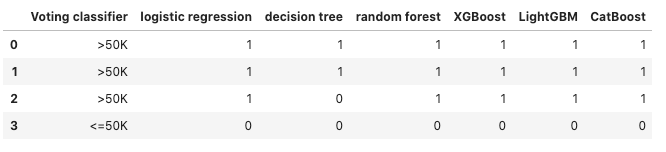
        
    - `voting='soft'`
        - it averages the output of `predict_proba`, and then thresholds/takes the larger one.
        - therefore, you get scores.
        
        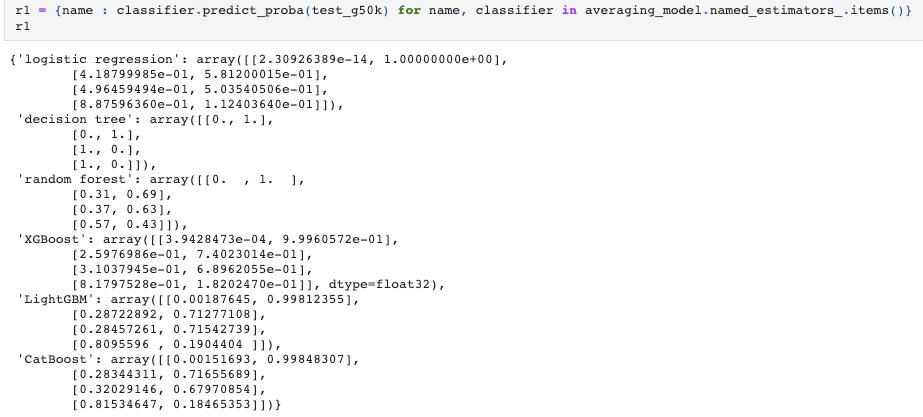

#### 3.3 Advantage of `VotingClassifier`
- As long as the different models make different mistakes, this works great.
- For example, in this case:

    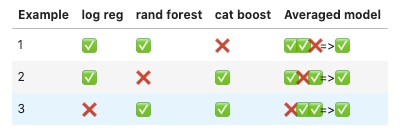
    
    - Averaging model works better than the individual models.
    

**Disadvantage**
- Increases `fit`/`predict` time (slow)
- Reduction in interpretability
- Reduction in code maintainability

#### 3.4 What kind of estimators can we combine?

- You can combine
    - completely different estimators, or similar estimators.
    - estimators trained on different samples.
    - estimators with different hyperparameter values.

There is no correct answer.

### 4. Stacking

#### 4.1 `StackingClassfier`
- Instead of averaging the outputs of each estimator, instead use their outputs as **inputs** to another model.
- By default for classification, it uses logistic regression.
    - the features going into the logistic regression are the classifier outputs, not the original features.
    - the number of coefficients = the number of base estimators
    
- Steps
    - 1) Training data (m x n)
        - We split the training data into k-folds just like k-fold cross validation
    - 2) This training data goes inside different models
        - A base model is fitted on the k-1 parts and predictions are made for the kth part
        - We do this each part of the training data
    - 3) Then we take the prediction from these models and combine then to form a new matrix. (m x M where M is the number of models)
        - The base model is then fitted on the whole train dataset to calculate its performance on the test set
    - 4) This data is then used for the second level model 
        - The predictions from the train set are used as features for the second level model
    - 5) Then second level model makes a decision.
    
```python
from sklearn.ensemble import StackingClassifier
stacking_model = StackingClassifier(list(classifiers_nocat.items()))
stacking_model.fit(X_train, y_train);
```
- It does cross-validation by itself by default.
    - It is fitting the base estimators on the training fold
    - And the predicting on the validation fold
    - And then fitting the **meta-estimator** (in this case, `logistic regression`) on that output (on the validation fold)
    
```python
pd.DataFrame(data=stacking_model.final_estimator_.coef_[0], index=classifiers_nocat.keys(), columns=["Coefficient"])
```

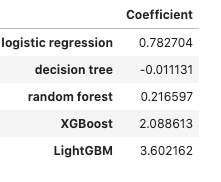

- If you look at the coefficients, `LightGBM` is the most trusted model.


```python
stacking_model_tree = StackingClassifier(list(classifiers_nocat.items()), 
                 final_estimator=DecisionTreeClassifier(max_depth=3))
```

- You can use `DecisionTreeClassifier` as a final estimator.
- The result won't be great, but it can visualize as a tree.

#### 4.2 Advantage / Disadvantage

1. Advantage
    - You may get a better score.


2. Disadvantage
    - Slow
    - More code maintenance

#### 4.3 Effective strategy for stacking
- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

### Summary
- Ensembles are usually pretty effective.
    - Tree-based classifiers are particularly popular and effective on a wide range of problems.
    - But they trade off **code complexity and speed** for prediction accuracy.
    - Don't forget that hyperparameter optimization multiplies the slowness of the code!

- Stacking is a bit slower than voting, but generally higher accuracy.
    - As a bonus, you get to see the coefficients for each base classifier. (meta estimator = lr)
- All the above models have equivalent regression models.

## Lecture 6: Feature Importances beyond Linear Models and Loss Functions

### 1. Why is interpretability important in ML?
- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
    - Can give explanation why a certain prediction is made. 
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems.

### 2. Feature importances in linear models
- Simpler models are often more interpretable but less accurate.
- By looking at coefficients of features, you can see which feature is being considered as a more important feature. 

```python
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df[:10]
```

### 3. Model interpretability beyond linear models

#### 3.1 `feature_importances_`
- For tree-based models, importance of a feature is calculated based on **impurity** (gini index or information gain)


```python
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps
```

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**.
    - They tell us about importance, but not an "up or down".
    - Indeed, increasing a feature may cause the prediction to first go up, and then go down. (because they are not linear!)


- The importances with `feature_importances_` on non-linear models are usually not comparable with coefficients of linear models.
    - They pick important features differently 

#### 3.2 `eli5`

```python
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_xgb.fit(X_train, y_train)
eli5.explain_weights(pipe_xgb.named_steps["xgbclassifier"], feature_names=feature_names)
```

- The results with `eli5` are pretty similar to a result with `feature_importances_`
- However, this cannot tell us an explanation about a specific prediction. (just tell us globally which features are important)

#### 3.3 `SHAP` (SHapley Additive exPlanations)

**General Idea**
- Start at a base rate, add one feature at a time and see how it impacts the decision.


**Getting SHAP values**
```python
import shap

explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])  # construct an explainer

# create a dataframe with our transformed features
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)

# Calculate SHAP values on a sample of the training data
# There will be a SHAP value for each example and each feature.

rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_enc)
```

- The result gives SHAP arrays both classes.

```python
# extract the important features for the first class
values = np.abs(shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)   
```


**SHAP plots**

**1. Force plot**

```python
shap.initjs()

shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][11, :],
    X_train_sample.iloc[11, :],   # example 11
    matplotlib=True,
)
```

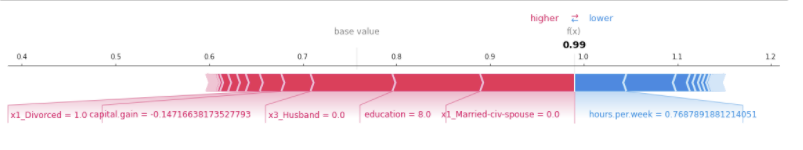

- Everything is with respect to class 0
- If the base value is smaller than the SHAP value of an example, then the class of the prediction will be "1"
- If the base value if higher than the SHAP value, then the class of the prediction will be "0"
    - Features that push the prediction to a higher value are shown in red.
    - Features that push the prediction to a lower value are shown in blue.
    
```python
shap_values[0][11].sum() + explainer.expected_value[0]
>>> 0.990000000137823
```
- If we **sum up the feature importances**, it will be **the prediction value**.
- The value is the same as `predict_proba` score for class 0.


**2. Summary plot**

```python
shap.summary_plot(shap_values[0], X_train_sample)
```

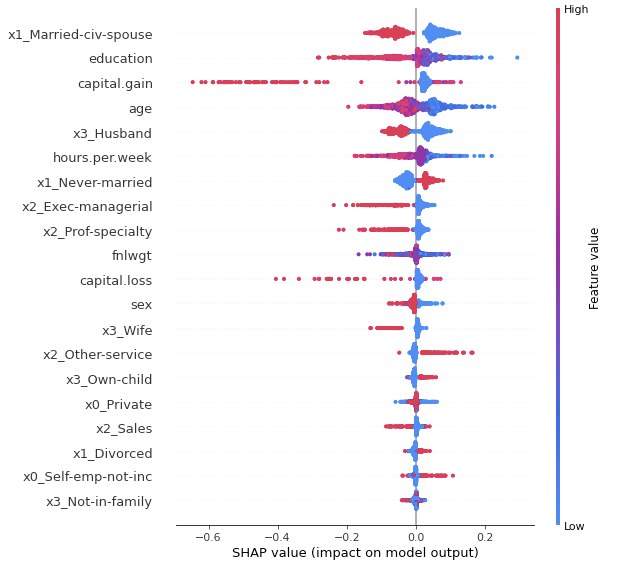

- The plot shows the most important features for predicting the class.
- It also shows the direction of how it's going to drive the prediction.
- The features are ordered by averaged importance. 
- Higher SHAP value means positive association with class 0 (`shap_values[0]`)

**3. Dependence plot**

```python
shap.dependence_plot("age", shap_values[0], X_train_sample)

```

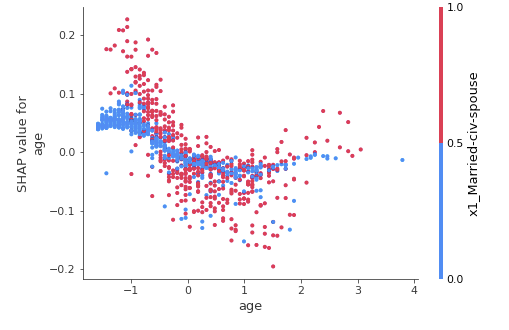

- Shows effect of `age` feature on the prediction
- Each dot is a single prediction
- Lower values of age have higher SHAP values for class 0.
- The colour corresponds to a second feature that may have an interaction effect with the feature we are plotting.

#### 3.4 Usefulness of these tools

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
    - New features related to useful features -> better results.
    - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions.
    - Debugging, if the model is behaving strangely.
    - Regulatory requirements.
    - Fairness / bias.
    - Keep in mind this can be use on deployment predictions!

### 4. Loss Function

- Least squares for linear regression:
$$\sum_{i=1}^n \left(w^Tx_i - y_i\right)^2$$

- The function that we're minimizing is called the loss function.
    - It's a method of evaluating how well specific algorithm models the given data.
- We get different fits by changing the loss function.


#### 4.1 Mean vs median

- The mean is the number that minimizes the **squared loss** between itself and the set of numbers.
    - sensitive to outliers
- The median is the number that minimizes the **absolute loss** between itself and the set of numbers.
    - less sensitive to outliers
    
   
#### 4.2 Three steps of ML

- 1. Choose your model
- 2. Choose your loss function
- 3. Choose your optimization algorithm

- The model controls the space of possible functions from $X$ to $y$.
    - For example, a linear model can only learn linear functions.
- The loss function tells us how to compare these various functions.
    - For example, is $y=2x_1+3x_2$ a better model than $y=10x_1-x_2$?
- The optimization algorithm computationally finds the minimum of the loss function.


#### 4.3 SVM vs LogisticRegression
- Both are linear classifiers, but they use different loss functions. 
- Therefore, how they predict an example will be different even though they show the same result.

## Lecture 7: Regularization

### 1. Why do we need regularization?
- For example, fitting polynomial:
    - Training score goes up as we increase the degree of the polynomial (= as we increase the number of features).
    - However, we start overfitting after p = 3. -> a tradeoff between complexity of models and the validation score
    - But, what if we need complex models?
        - We might need high-degree polynomial.
        - We might need to use many features, and don't know "relevant" ones. 

> We can use **regularization** to control the complexity of the model. (another way of controlling the complexity of a model is model averaging such as random forests -> high number of trees are always good)

### 2. Idea of regularization: Pick the line/hyperplane with smaller slope
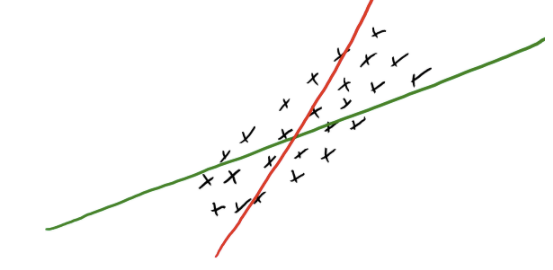

- Small change in $x_i$ has a smaller change in prediction $y_i$
- Green line's predictions are **less sensitive** to the training data.
- Since green $w$ (weight, or slope) is less sensitive to training data, **validation error might be lower**.
- The general idea of regularization is making $w$ less sensitive to the data.

#### 2.1 Terminology and notation: L0, L1, and L2 norms

- L0 "norm" $\lVert w \rVert \rightarrow$ the number of non-zero elements in $w$
- L1 norm $\lVert w \rVert_1 = \lvert w_1 \rvert + \lvert w_2 \rvert + \dots + \lvert w_n \rvert$ (absolute sum)
- L2 norm $\lVert w \rVert_2 = (w_1^2 + w_2^2 + \dots + w_n^2)^{1/2}$ (square root of squared sum)

```
The l0 norm of [0 2 4] is: 2.000 (# of features = 2)
The l1 norm of [0 2 4] is: 6.000 (|2| + |4| = 6)
The l2 norm of [0 2 4] is: 4.472 (sqrt(2^2 + 4^4) = sqrt(20))
```

```
The l0 norm of [ 1 -2  3  0] is: 3.000
The l1 norm of [ 1 -2  3  0] is: 6.000
The l2 norm of [ 1 -2  3  0] is: 3.742
```

### 3. L0 regularization

**Least squares loss before applying penalty:** 

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 \text{ or }\\
f(x) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2$$ 

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$




**Least squares loss after applying L0 penalty:**

$$f(w) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2 + \lambda \lVert w\rVert_0$$

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$
- $\lambda \rightarrow$ penalty parameter
- $\lVert w\rVert_0 \rightarrow$  L0 norm of $w$      
    - The number of **non-zero** values in $w$. (number of features)

### 4. L2 regularization

#### 4.1 L2 penalty
- Standard regularization strategy
- We incorporate L2 penalty in the loss function $f(w)$
- L2 penalty is a continuous penalty

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d w_j^2 \text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- $\lVert Xw - y\rVert_2^2 \rightarrow$ square of the $L2$ norm of $Xw -y$
- $\lambda \rightarrow$ regularization strength    
- $\lVert w\rVert_2^2 \rightarrow$  square of the L2 norm of $w$      
    - sum of the squared weight values.        
- Objective balances getting **low error vs. having small slopes $w_j$**
- In terms of fundamental trade-off:
    - You can increase the training error.
    - Nearly-always reduces overfitting and the validation error.

#### 4.2 Models with L2 regularization
- Ridge (linear regression with L2 regularization):
    - uses the hyperparameter $\alpha$ for regularization strength instead of $\lambda$
    - **larger** $\alpha$ -> **more** regularization

- Logistic regression with L2 regularization:
    - $C$ : default = 1.0. 
    - **Inverse of regularization strength**, must be **a positive** float.
    - **Smaller** values of C -> **stronger** regularization.

#### 4.3 Size of regression weights and overfitting
- Bigger values of weights means the model is very sensitive to the training data

**No regularization (`alpha = 0`)**

|   | degree | train_score | valid_score | weights                                                                                                                                                                           |
|---|--------|-------------|-------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0 | 1      | 0.796       | 0.77        | [5.743]                                                                                                                                                                           |
| 1 | 2      | 0.826       | 0.731       | [5.743, 0.688]                                                                                                                                                                    |
| 2 | 4      | 0.977       | 0.872       | [0.069, 1.806, 0.954, -0.132]                                                                                                                                                     |
| 3 | 6      | 0.977       | 0.871       | [-0.235, 1.737, 1.099, -0.111, -0.013, -0.002]                                                                                                                                    |
| 4 | 15     | 0.988       | 0.877       | [2.65, -3.544, -23.958, 4.97, 42.755, -1.932, -28.846, 0.378, 9.49, -0.043, -1.621, 0.003, 0.138, -0.0, -0.005]                                                                   |
| 5 | 20     | 1.0         | 0.85        | [9.922, -55.976, -114.727, 542.503, 351.067, -1679.367, -478.091, 2333.862, 347.236, -1705.769, -144.523, 708.765, 35.294, -172.262, -4.966, 24.104, 0.371, -1.79, -0.011, 0.054] |

- As the number of degrees (features) increases, the weights become very large.
- So for higher degree polynomials, the model would be very sensitive to the data.

**Add regularization (`alpha = 100`)**

|   | degree | train_score | valid_score | weights                                                                                                                                 |
|---|--------|-------------|-------------|-----------------------------------------------------------------------------------------------------------------------------------------|
| 0 | 1      | 0.508       | 0.467       | [2.29]                                                                                                                                  |
| 1 | 2      | 0.534       | 0.448       | [2.29, 0.437]                                                                                                                           |
| 2 | 4      | 0.964       | 0.879       | [0.124, 0.222, 0.913, 0.04]                                                                                                             |
| 3 | 6      | 0.966       | 0.87        | [0.183, 0.114, 0.534, 0.265, 0.05, -0.025]                                                                                              |
| 4 | 15     | 0.977       | 0.875       | [0.058, 0.032, 0.097, 0.069, 0.119, 0.106, 0.086, 0.089, -0.016, -0.048, -0.0, 0.007, 0.0, -0.0, -0.0]                                  |
| 5 | 20     | 0.979       | 0.87        | [0.05, 0.013, 0.087, 0.024, 0.115, 0.031, 0.109, 0.036, 0.04, 0.036, -0.05, 0.02, 0.015, -0.025, -0.002, 0.007, 0.0, -0.001, -0.0, 0.0] |

- If we regularize the weights for a complex model ($p = 20$), the weights are small
- It means that we are less sensitive to the data.

#### 4.4 Why are small weights better?
- If we change feature1 value by a small amount $\epsilon$ in $x_2$, leaving everything else the same, we might think that the prediction would be the same.
- But if we have bigger weights small change in $x_2$ has a large effect on the prediction.

```python
x_1 = np.array([1, 1, 0, 1, 1, 0])
x_2 = np.array([0.8, 1, 0, 1, 1, 0])
weights = np.array([100, 0.1, 1, 0.22, 4, 3])

print("x_1 prediction: ", x_1.dot(weights))
print("x_2 prediction: ", x_2.dot(weights))

>>> x_1 prediction:  104.32
>>> x_2 prediction:  84.32
```

- In linear models, the rate of change of the prediction function is proportional to the individual weights.
- So if we want **the function to change slowly**, we want to ensure that the **weights stay small**.
- The idea is to avoid putting all our energy into one features, which might give us over-confident predictions and lead to overfitting.

#### 4.5 `alpha` and the weights: fundamental trade-off

|   | alpha  | train_score | valid_score | weights                                                                      |
|---|--------|-------------|-------------|------------------------------------------------------------------------------|
| 0 | 0.0001 | 0.98        | 0.873       | [-0.722, -2.847, 1.487, 3.789, -0.069, -1.175, -0.003, 0.145, 0.001, -0.006] |
| 1 | 0.001  | 0.98        | 0.873       | [-0.719, -2.824, 1.483, 3.77, -0.067, -1.169, -0.003, 0.144, 0.001, -0.006]  |
| 2 | 0.01   | 0.98        | 0.873       | [-0.689, -2.608, 1.444, 3.589, -0.053, -1.115, -0.005, 0.137, 0.001, -0.006] |
| 3 | 0.1    | 0.98        | 0.873       | [-0.47, -1.353, 1.161, 2.529, 0.053, -0.792, -0.02, 0.097, 0.001, -0.004]    |
| 4 | 1.0    | 0.979       | 0.874       | [-0.007, 0.205, 0.539, 1.07, 0.288, -0.323, -0.054, 0.036, 0.003, -0.001]    |
| 5 | 10.0   | 0.977       | 0.875       | [0.11, 0.248, 0.285, 0.399, 0.382, -0.011, -0.066, -0.012, 0.004, 0.001]     |
| 6 | 100.0  | 0.974       | 0.872       | [0.076, 0.06, 0.182, 0.122, 0.309, 0.127, -0.039, -0.032, 0.002, 0.002]      |
| 7 | 1000.0 | 0.957       | 0.855       | [0.022, 0.015, 0.053, 0.042, 0.1, 0.073, 0.027, -0.014, -0.003, 0.001]       |

- High alpha -> smaller weights (close to zero, but **never become zero**!)
- As alpha goes up, the model becomes **smoother**

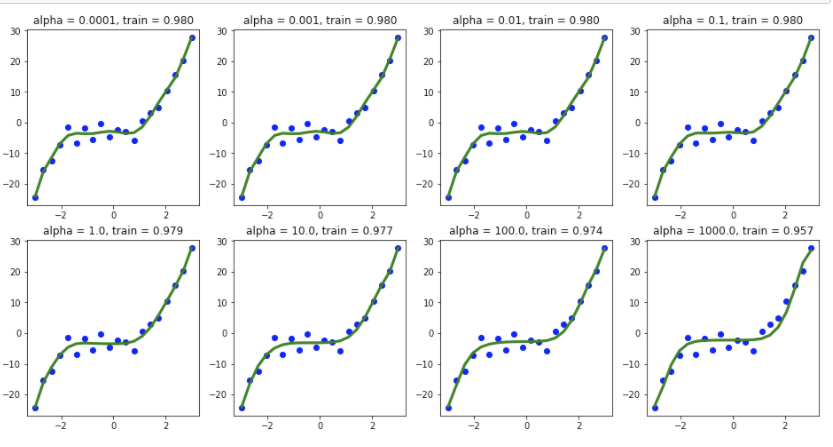

- Strong regularization means our complex model becomes smoother.
- They won't have much impact on prediction.
- Strong regularization means the **results are not too sensitive** to the training data.
- We are **keeping the complexity of the model** but making it **less sensitive to the feature values**!
    - This is because L2 regularization never make weights to be 0. (0 weights means we are not using the feature -> simpler model)

#### 4.6 L2-Regularization "Shrinking" Example

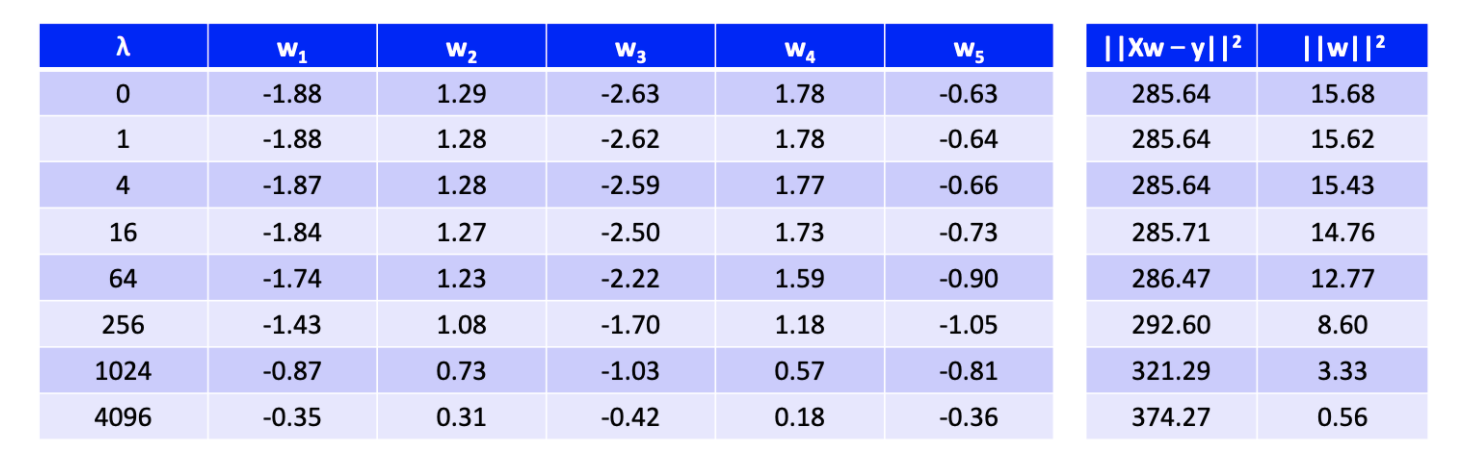

- We get least squares with $\lambda = 0$.
- But we can achieve similar training error with smaller $\lVert w\rVert^2$.
- $\lVert Xw - y\rVert^2$ increases with $\lambda$, and $\lVert w\rVert^2$ decreases with λ.
    - Though individual $w_j$ can increase or decrease with lambda because we use the L2-norm, the large ones decrease the most.
    
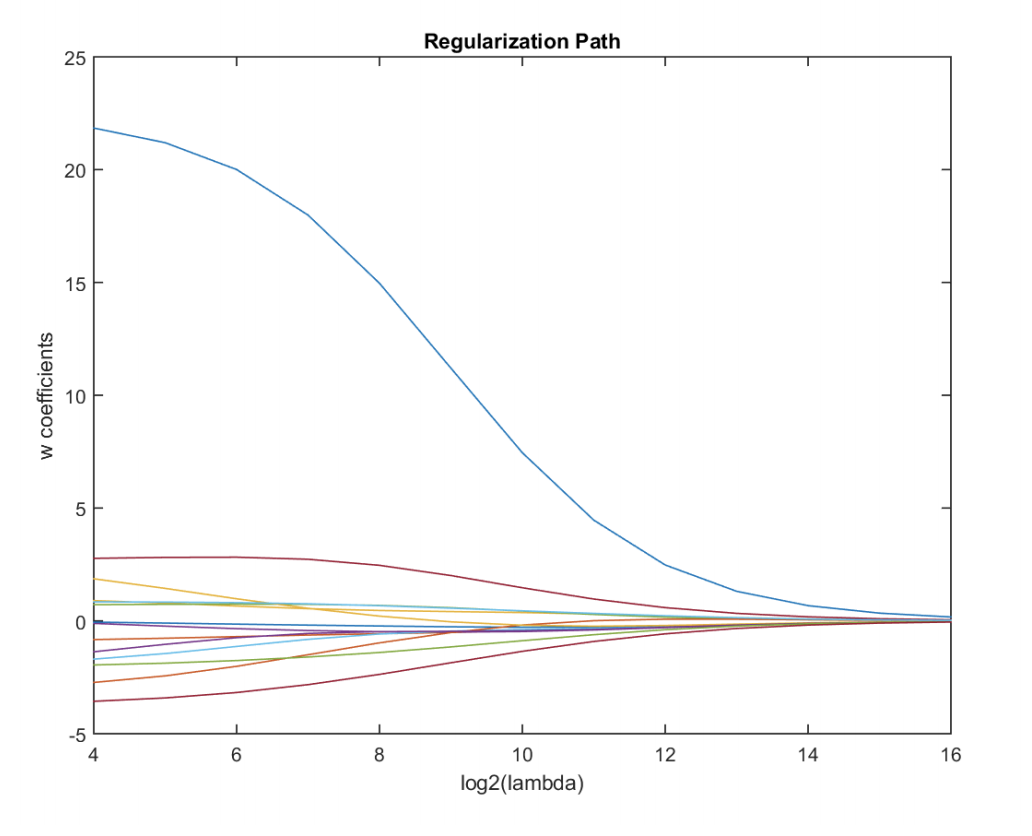

- w coefficients shrink and converge to zero as lambda grows but they do not become 0.

#### 4.7 How to pick $\lambda$?
- Theory: as $n$ grows $\lambda$ should be in the range $O(1)$ to $\sqrt{n}$.
- Practice: optimize validation set or cross-validation error.
- Almost always decreases the test error.

#### 4.8 Some properties of L2 regularization
1. Solution $w$ is **unique**. (We are not going into mathematical details.)
2. Almost **always improves** the validation error.
3. **No collinearity** issues.
4. **Less sensitive** to changes in $X$.
5. Gradient descent converges faster (bigger $\lambda$ means fewer iterations). (You'll learn about Grafient descent in 572.)
6. Worst case: just set $\lambda$ small and get the same performance

#### 4.9 Summary of L2
- Change the loss function by adding a continuous penalty on the model complexity.
- Best parameter $\lambda$ almost already leads to improved validation error.
    - L2-regularized least squares is also called "ridge regression".
    - Can be solved as a linear system like least squares.
- Some benefits of L2 regularization
    - Solution is unique.
    - Less sensitive to data.
    - Fast.

#### 4.10 Example

- Imagine the following two weight vectors which give the same validation errors. 
$$w^1 = \begin{bmatrix}100 \\0\end{bmatrix}  w^2 = \begin{bmatrix}99.98 \\0.03\end{bmatrix}$$  

- Which one would be chosen by L0 regularization? 
    - $\lVert w^1\rVert_0 = 1$ and $\lVert w^2\rVert_0 = 2$. So it will pick $w^1$
- Which one would be chosen by L2 regularization? 
    - L2 regularizer focuses on decreasing the largest weight smaller. 
    - $99.98^2 + 0.03^2 = 9996.0013$ < $100^2 = 10000$

### 5. L1 regularization

#### 5.1 L1 penalty

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d \lvert w_j \lvert\text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$


- $\lambda \rightarrow$ regularization strength
- $\lVert w\rVert_1 \rightarrow$  L1 norm of $w$  
- Objective balances getting **low error vs. having small values for $w_j$**

#### 5.2 Similarities with L2 regularization
- Both shrink weights
- Both result in lower validation error

#### 5.3 Ridge and Lasso
- Linear regression model that uses L2 regularization: Ridge
- Linear regression model that uses L1 regularization: Lasso

```python
deg = 10
alphas = 10.0 ** np.arange(-4, 4)
data = {}
for alpha in alphas:
    pipe_poly_lasso = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False),
        Lasso(alpha=alpha, max_iter=1000),
    )
    pipe_poly_lasso.fit(X_train, y_train)
```

|   | alpha  | train_score | valid_score | weights                                                               |
|---|--------|-------------|-------------|-----------------------------------------------------------------------|
| 0 | 0.0001 | 0.978       | 0.873       | [-0.428, 1.632, 1.288, -0.019, -0.045, -0.018, -0.001, 0.0, 0.0, 0.0] |
| 1 | 0.001  | 0.978       | 0.873       | [-0.418, 1.623, 1.282, -0.016, -0.044, -0.018, -0.001, 0.0, 0.0, 0.0] |
| 2 | 0.01   | 0.978       | 0.873       | [-0.313, 1.547, 1.218, 0.013, -0.034, -0.022, -0.001, 0.0, 0.0, 0.0]  |
| 3 | 0.1    | 0.978       | 0.874       | [-0.0, 1.058, 1.004, 0.159, 0.001, -0.033, -0.002, -0.0, 0.0, 0.0]    |
| 4 | 1.0    | 0.972       | 0.867       | [0.0, 0.0, 0.434, 0.288, 0.148, -0.006, -0.008, -0.005, -0.0, 0.0]    |
| 5 | 10.0   | 0.951       | 0.853       | [0.0, 0.0, 0.0, 0.0, 0.131, 0.024, 0.019, 0.001, -0.002, -0.0]        |
| 6 | 100.0  | 0.922       | 0.85        | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.004, -0.003, -0.0]            |
| 7 | 1000.0 | 0.764       | 0.756       | [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0]                  |

- Smaller `alpha` -> higher weights
- Larger `alpha` -> smaller weights
- Many weights become **zero** -> **sparcity up**

#### 5.4 Sparcity in L1 regularization
- We say a linear function is sparse if most of the coefficients are zero.

$$0x_1 + 0.45 x_2 + 0  x_3 + 0x_4 + 1.2x_5 + 0x_6 + 0x_7 + 0x_8$$

#### 5.5 Similarities between L1 and L0 regularization

- Like L0-norm, it encourages elements of $w$ to be exactly zero.
- L1-regularization **simultaneously regularizes and selects features**.
- Very fast alternative to search and score (L0 penalty).

#### 5.6 Example

$$w^1 = \begin{bmatrix}100 \\-0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- L0 regularization will choose $w2$ (smallest number of features)
- L1 regularization will choose $w2$ as well
    - $\lVert w^1\rVert_1 = 100.02$
    - $\lVert w^2\rVert_1 = 100$
    - $\lVert w^3\rVert_1 = 100.01$
- L2 regularization will choose $w3$
    - $\lVert w^1\rVert_2^2 = (100)^2 + (0.02)^2 = 10000.0004$
    - $\lVert w^2\rVert_2^2 = (100)^2 = 10000$
    - $\lVert w^3\rVert_2^2 = (99.99)^2 + (0.02)^2 = 9998.0005$
    - L2-regularization focuses on **decreasing largest $w_j$ smaller**

#### 5.7 Some properties of L1 regularization
1. Almost always improves the validation error (same as L2)
2. Can learn with exponential number of irrelevant features
3. Less sensitive to changes in X
4. The solution is not unique (unlike L2)

### 6. Feature selection using L1 regularization
- L1 can be an effective way of feature selection (vs. RFE, search and score with L0 regularization - forward search)

#### 6.1 `LassoCV()`

```python
from sklearn.feature_selection import SelectFromModel

pipe_l1_ridgecv = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    SelectFromModel(LassoCV(max_iter=2000)),  # feature selection with L1 regularization
    RidgeCV(),
)
```

|             | RFE Ridge         | L1 regularization |
|-------------|-------------------|-------------------|
| fit_time    | 1.264 (+/- 0.056) | 0.425 (+/- 0.066) |
| score_time  | 0.002 (+/- 0.000) | 0.002 (+/- 0.000) |
| test_score  | 0.802 (+/- 0.088) | 0.815 (+/- 0.078) |
| train_score | 0.907 (+/- 0.035) | 0.919 (+/- 0.014) |

- L1 regularization is much faster!

#### 6.2 Extract selected feature names by `LassoCV()`

```python
poly_feature_names = pipe_l1_ridgecv.named_steps[
    "polynomialfeatures"
].get_feature_names()  # transformed list to array
support = (
    np.abs(pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_)
    > pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_
)
l1_selected_feats = np.array(poly_feature_names)[support]
l1_selected_feats
```


### 7. Logistic regression with regularization
#### 7.1 Logistic regression with L2 regularization (default)
- In sklearn, by default logistic regression uses L2 regularization.

```python
pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression())
results_classification["Logistic Regression L2"] = mean_std_cross_val_scores(
    pipe_lgr_l2, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
```

- All coefficients are non-zero

#### 7.2 Logistic regression with L1 regularization

```python
pipe_lgr_l1 = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", penalty="l1") # specify L1 regularization
)
results_classification["Logistic Regression L1"] = mean_std_cross_val_scores(
    pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
```

- This carries out feature selection
- Many coefficients are 0.

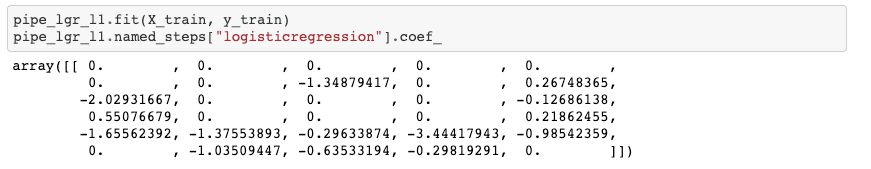

#### 7.3 L1 regularization with another models

```python

from lightgbm.sklearn import LGBMClassifier
pipe_lgr_lgbm = make_pipeline(
    StandardScaler(),
    SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1")),  # use SelectFromModel()
    LGBMClassifier(),
)
```

### 8. Regularization: scaling and collinearity

#### 8.1 Importance of scaling
- It doesn't matter for decision trees or naive Bayes.
    - They only look at one feature at a time.
- It doesn't matter for least squares:
    - $w_j*(100 mL)$ gives the same model as $w_j*(0.1 L)$ with a different $w_j$
- It **matters** for $k$-nearest neighbours:
    - Distance will be affected more by large features than small features.
- It **matters for regularized least squares**:
    - Penalizing $w_j^2$ means different things if features $j$ are on different scales
    - Penalizing $w_j$ means different things if features $j$ are on different scales
    
#### 8.2 Scaling in linear regression
- Un-regularized linear regression: not affected by scaling
- **L1 or L2-regularized linear regression**: both affected by scaling (and it's usually a good idea)

### 9. Collinearity and regularization
- If you have colinear features, the weights would go crazy with regular linear regression.
- With L2 regularization: The weight will be **equally distributed among all collinear features** because the solution is unique.
    - Example: suppose we have three identical features with a total weight of 1
    - The weight will be distributed as 1/3, 1/3, 1/3 among the features.

- With L1 regularization: The weight will **not be equally distributed**; the solution is not unique.
    - Example: suppose we have three identical features with a total weight of 1
    - The weight could be distributed in many different ways
    - For example, 1/2, 1/4, 1/4 or 1.0, 0, 0 or 1/2, 1/2, 0 and so on ...

#### 9.1 Elastic nets

- Combine good properties from both worlds
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda(\alpha\lVert w\rVert_1 + (1-\alpha)\lVert w\rVert_2^2 )  $$
- $\lambda$ control the strength of regularization
- $\alpha$ controls the amount of sparsity and smoothness
- L1 promotes sparsity and the L2 promotes smoothness.
- The functional is strictly convex: the solution is unique.
- No collinearity problem
    - A whole group of correlated variables is selected rather than just one variable in the group.

### 10. Summary
#### 10.1 Using regularization with models
- Regression:
    - Least squares with L2-regularization: Ridge
    - Least squares with L1-regularization: Lasso
    - Least squares with L1- and L2-regularization: ElasticNet
    - SVR ($\epsilon$-insensitive loss function)
        - epsilon = 0 gives us KernelRidge model (least squares with RBF)
- Classification
    - SVC (supports L2-regularization)
    - LogisticRegression (support L1 and L2 with different solvers)

#### 10.2 L* regularization

- L0-regularization (AIC, BIC, Mallow’s Cp, Adjusted R2, ANOVA):
    - Adds penalty on the number of non-zeros **to select features**.
    
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_0$$

- L2-regularization (ridge regression):

    - Adding penalty on the L2-norm of $w$ **to decrease overfitting**:
    
    $$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$
    
- L1-regularization (lasso regression):

    - Adding penalty on the L1-norm **decreases overfitting and selects features**:
    
    $$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$


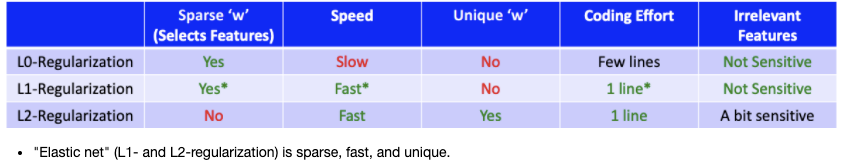

## Lecture 8: More about Logistic Regression

### 1. Logistic Regression: `predict`

#### 1.1 Logistic regression: $w$ and $b$
- Logistic regression learns the weights $w$ and bias or intercept $b$
- There's one coefficient per feature, plus an intercept, just like linear regression.
- We combine our features and coefficients with a dot product:
$$
\begin{split}
z = w_1x_1 + \dots w_dx_d + b\\
= w^Tx + b
\end{split}
$$


#### 1.2 "Column of ones" trick
- We can ignore the intercept $b$ because of the "column of ones" trick
- We rename bias term as $w_0$ and introduce a dummy feature $x_0$ whose value is always 1.
- So $w_1x_1 + \dots + w_nx_n + b$ becomes $w_0x_0 + w_1x_1 + \dots + w_nx_n$, where $x_0$ is always 1.

- Suppose $X$ has only one feature, say $x_1$: 
$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
- Make a new matrix $Z$ with an extra feature (say $x_0$) whose value is always 1. 
$$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$
- Use $Z$ instead of $X$. 

#### 1.3 Vectorization
- We can organize all the training examples into a matrix $Z$ with one row per training example.
- Then compute the predictions for the whole dataset succinctly as $Zw$ for the whole dataset
- We take each row of $Z$ and dot-product it with $w$. So the result is a vector of all our predictions.

$$Zw = \begin{bmatrix}w^Tz_0 \\ w^Tz_1 \\ \vdots \\ w^Tz_n\end{bmatrix} = \begin{bmatrix}z_0w \\ z_1w \\ \vdots \\ z_nw\end{bmatrix} = \begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix} $$

```python
y_hat = np.dot(Z, w)
y_hat[:10]

>>> array([ 0.36877753,  1.04661623,  0.91654494, -0.17603719,  1.42893646,
        0.51584516,  1.05058312,  0.82968848,  1.30954244,  0.40445746])
```

#### 1.4 Scores to probabilities
- The numbers above are "raw model output" -> This is the prediction for linear regression
- For logistic regression, you can check the "**sign**" of this value. 
    - If positive, predict +1; if negative, predict -1. (hard predictions)
- Predicted probabilities: "soft predictions"
    - To convert the raw model output to probabilities, we apply the sigmoid.
    
**The sigmoid function**
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$.

$$\frac{1}{1+e^{-x}}$$ 

- Then we can interpret the output as probabilities.

```python
sigmoid(y_hat)[:10]
>>> array([0.59116355, 0.74012459, 0.71433759, 0.456104  , 0.80673555,  # threshold - 0.5
       0.62617571, 0.74088686, 0.69628906, 0.78743658, 0.59975814])
```

**Decision boundary of logistic regression**
- The decision boundary is a $d-1$ dimensional hyperplane dividing the feature space in half. ($d$ - number of features)
- The coefficients: controls the orientation of the boundary

**Prediction with learned weights**

```python
np.dot(example.tolist(), lr.coef_.flatten())
>>> 1.9823
```
- The value here is positive, so we predict the class 1. 

**Predicting probabilities**

1. `model.predict_proba`

```python
lr.predict_proba([example])

>>> array([[0.12106912, 0.87893088]])
```

2. `sigmoid()`

```python
sigmoid(np.dot(example.tolist(), lr.coef_.flatten()))

>>> 0.8789308811659498
```

- We get the same probability score. 
- Generally we use regularization with logistic regression. 
- By default, `sklearn`'s logistic regression uses `l2` penalty with `C=1.0`, where `C` is inverse of regularization strength; **smaller values specify stronger regularization**.

### 2. Logistic Regression: `fit`

#### 2.1 Goal of fitting in logistic regression
- Learn parameters $w$ and $b$ which make predictions for each training example as close as possible to the true $y$. 
- We need two things: 
    - **Loss function**: A metric to measure how much a prediction differs from the true $y$. 
    - **Optimization algorithm**: for iteratively updating the weights so as to minimize the loss function. (More on this in 572.)   
- Assumption: We are going to assume that your classes are -1 and +1.

#### 2.2 Least squares loss function for logistic regression
- The least squares loss function doesn't make sense for logistic regression

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- Example: 
    - Suppose $w^Tx_i$ (prediction) is 101 and $y_i$ is $+1$. 
    - The model is behaving correctly, because $101$ is positive and so it will predict $+1$.
    - But according to this loss function, you have a bad prediction because the loss is huge: $(101 - 1)^2 = 10000$. 
- The squared error doesn't make sense here.    
    - It does not make sense to compare **raw model outputs which can be any number to 1 or -1.**

#### 2.3 Loss function for logistic regression?

$$f(w) = -\sum_{i=1}^n y_iw^Tx_i$$ 


**Key idea**
- **Multiply $y_iw^Tx_i$**. 
- We always want this quantity to be **positive** because
- If $y_i$ and $w^Tx_i$ have the _same sign_, the product will be positive.
    - $w^Tx_i$ is positive and $y_i$ is positive 🙂
    - $w^Tx_i$ is negative and $y_i$ is negative 🙂
- If they have _oppositve signs_, the product will be negative.
    - $w^Tx_i$ is positive and $y_i$ is negative 😔 
    - $w^Tx_i$ is negative and $y_i$ is positive 😔
    
- By making this small (minimize neg cases), we encourage the model to make **correct predictions**.  
- The above loss _does not quite work out_. (I believe it has no minimum in most cases.)

#### 2.4 Logistic loss

$$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$

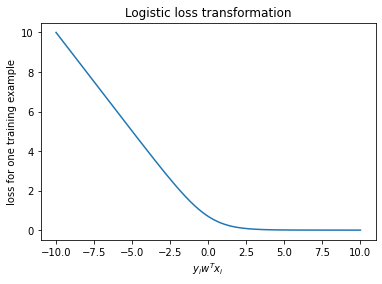

In [4]:
import matplotlib.pyplot as plt
import numpy as np

grid = np.linspace(-10,10,1000)
fun = lambda z: np.log(1+np.exp(-z))
plt.plot(grid, fun(grid));
plt.xlabel("$y_iw^Tx_i$");
plt.ylabel("loss for one training example")
plt.title("Logistic loss transformation");

**Intuition**
- The function gets smaller as $y_iw^Tx_i$ gets larger, so it encourages correct classification
- If we minimize this loss, which means if we move down and to the right, it is encouraging positive values and hence correct predictions.

#### 2.5 Sigmoid vs. Logistic loss

**Sigmoid function**

$$\frac{1}{(1+\exp(-z))}$$
- Maps $w^Tx_i$ to a number in $[0,1]$, to be **interpreted as a probability**. 
- This is important in **`predict_proba`**. 

**Logistic loss**

$$\log(1+\exp(-z))$$
- Maps $y_iw^Tx_i$ to **a positive number**, which is the **loss contribution** from one training example. 
- This is important in **`fit`**.

### 3. Implementing logistic loss function

In [6]:
# This loss function works when our classes are -1 and 1.
def my_log_loss(w, X, y):
    return np.sum(np.log(1 + np.exp(-y*(X@w))))

```python
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_neg_1);

my_log_loss(np.squeeze(lr.coef_), X_train, y_train_neg_1)
>>> 92.8431566075896
```

- Or you can use `log_loss` function from `sklearn`

```python
from sklearn.metrics import log_loss

probs = lr.predict_proba(X_train)
log_loss(y_train_neg_1, probs, normalize=False)
```

**Cross-entropy loss**
- This assumes the classes to be 0 and 1.

**Error vs. Loss**
- Error is 1 - accuracy
    - This is not a smooth function -> hard to optimize
- Loss is different
    - This is a smooth function -> easy to optimize

### 4. Softmax

#### 4.1 Softmax function
- Standard way to convert numbers in a vector into a probability distribution
- Intuition
    - Exponentiate to put things in positive land
    - Normalize to give probability distribution

In [9]:
d = 10
vec = np.random.uniform(-4, 2, d)
vec

array([-1.86513643, -3.8518426 ,  1.72170459, -1.15849574, -0.91715349,
       -0.67718107,  0.1836918 ,  0.40575482, -2.84259569,  1.39571977])

In [10]:
# exponentiate -> positive
vec_exp = np.exp(vec)
vec_exp

array([0.15487508, 0.02124056, 5.59405592, 0.3139581 , 0.39965504,
       0.50804713, 1.20164541, 1.50043463, 0.05827421, 4.03787987])

In [11]:
# normalize -> probability distribution
vec_softmax = vec_exp/np.sum(vec_exp)
vec_softmax

array([0.01123092, 0.00154028, 0.40565839, 0.02276698, 0.02898137,
       0.03684153, 0.08713848, 0.10880547, 0.00422581, 0.29281077])

In [13]:
# softmax function
my_softmax = lambda z: np.exp(z)/np.sum(np.exp(z))
my_softmax(vec)

array([0.01123092, 0.00154028, 0.40565839, 0.02276698, 0.02898137,
       0.03684153, 0.08713848, 0.10880547, 0.00422581, 0.29281077])

#### 4.2 `LogisticRegression` with `multi_class="multinomial"`

- Do multi-class classification using a different loss function called `softmax loss` (categorical cross-entropy loss for logistic regression with multi-class)
- Intuition:
    - The loss tries to make the probability of the correct class large.
    - Which forces the rest to be small since they must add to 1.
    - It's a generalization of the logistic loss to multi-class.
- Note that softmax function and softmax loss although same in spirit are different things and have different purposes.

```python
lr_multi = LogisticRegression(multi_class="multinomial", max_iter = 2000)
lr_multi.fit(X_train, y_train);
```
- `predict_proba` of muti-class classification model is the output of softmax.
> For a multi_class problem, if multi_class is set to be “multinomial” the softmax function is used to find the predicted probability of each class. Else use a one-vs-rest approach, i.e calculate the probability of each class assuming it to be positive using the logistic function. and normalize these values across all the classes.

- It's actually the "soft max" because it's like the max function but "soft".

## True / False Qs

- Every tree in a random forest uses a different bootstrap sample of the training set. (T)
- To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features. (F)
- A reasonable implementation of predict_proba for random forests would be for each tree to "vote" and then normalize these vote counts into probabilities. (T)
- Increasing the hyperparameter max_features (the number of features to consider for a split) makes the model more complex and moves the fundamental tradeoff toward lower training error. (T)
- A random forest with only one tree is likely to get a higher training error than a decision tree of the same depth. _(F)_
    - True
    - (RF uses bootstrap samples. It only accesses to a subset of features. It is likely to have higher training error.)

- You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by feature_importances_ attribute of your model means that increasing the value of feat1 will drive us towards positive class. _(T)_
    - False
    - Because it is not a linear model, so there is no directional importance.
- eli5 can be used to get feature importances for non sklearn models. (T)
- With SHAP you can only explain predictions on the training examples. (F)
- When you add up the shapely values for an example and the expected value, you get the same score as predict_proba output. (T)
    - For random forest, yes
    - But for light GBM or CatBoost, no

- Introducing L2 regularization to the model means making it less sensitive to changes in $X$. 
- Introducing L2 regularization to the model can results in worse performance on the training set. 
- Imagine that you fit linear regression twice with different values of $\lambda$, $\lambda = 0$ and $\lambda=10$. You are given the weights learned from two different models below. Without knowing which weights came from which model, you can guess that $w^1$ probably corresponds to $\lambda = 10$ and $w^2$ probably corresponds to $\lambda = 0$. $$w^1 = \begin{bmatrix} 32.43\\23.14\\16.4\end{bmatrix} \text{ and }w^2 = \begin{bmatrix} 2.03\\1.2\\0.4\end{bmatrix}$$
- L2 regularization shrinks the weights but all $w_j$s tend to be non-zero.
- In L2 regularization, as $\lambda$ increases, $\lVert Xw –y\rVert_2^2$ decreases and $\lVert w\rVert_2^2$ increases. 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Both L0- and L1-regularization give sparsity but L2-regularization doesn't. 
- In L1-regularization, larger $\lambda$ selects few features and smaller $\lambda$ allows many features. $$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$
- L1-regularization tends to be a better choice than L2 regularization in most cases.
- Both L1- and L2-regularization shrink weights to zero. 

- When the term $y_iw^Tx_i$ in logistic loss is positive, it means we have a correct prediction.
- Minimizing logistic loss leads to mapping $y_iw^Tx_i$ to a positive number.
- Using least squares loss for logistic regression makes sense because logistic regression is very similar to linear regression except that it's used for classification.
- Logistic loss formulation we looked at expects the target values to be -1 and +1. 
- Sigmoid and logistic loss are basically the same thing with different names.

- Loss is basically the same as error (1 - accuracy) on the training set. 
- When you apply the softmax function you may end up messing up the scale of the numbers in your vector. 
- You can use logistic regression with softmax or multinomial cross-entropy loss for multi-class classification problems. 
- If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect the loss to go down. 
- If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect a lower training score but potentially higher CV score if it helped with overfitting. 